In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
import numpy as np
import astropy.units as u
from astropy.time import Time

import sys
sys.path.insert(0, '../')

In [73]:
from astropy.io import fits

f = fits.getdata('../libra/data/trappist_everest_luger.fits')
k2_time, k2_flux = f['TIME'][:-100] + 2454833, f['FLUX'][:-100], 

# Mask out strange fluxes
k2_flux /= np.median(k2_flux)

k2_time = k2_time[~np.isnan(k2_flux) & (k2_flux > 0.8) & (k2_flux < 1.2)]
k2_flux = k2_flux[~np.isnan(k2_flux) & (k2_flux > 0.8) & (k2_flux < 1.2)] 

p = np.polyfit((k2_time - k2_time.mean()), k2_flux, 5)
k2_flux -= np.polyval(p, k2_time - k2_time.mean())

# Remove flares
flare_times = np.loadtxt('flare_times.txt')
during_flares = np.any(np.abs(k2_time - flare_times[:, np.newaxis]) < 0.1, axis=0)

k2_time = k2_time[~during_flares]
k2_flux = k2_flux[~during_flares]
k2_err = np.ones_like(k2_flux) * np.std(k2_flux)/2

from scipy.signal import medfilt

# Mask outliers
median_filtered = medfilt(k2_flux, (5,))
outliers = np.abs((k2_flux - median_filtered)/k2_err) > 4

k2_time = k2_time[~outliers]
k2_flux = k2_flux[~outliers]
k2_err = k2_err[~outliers]

<Container object of 3 artists>

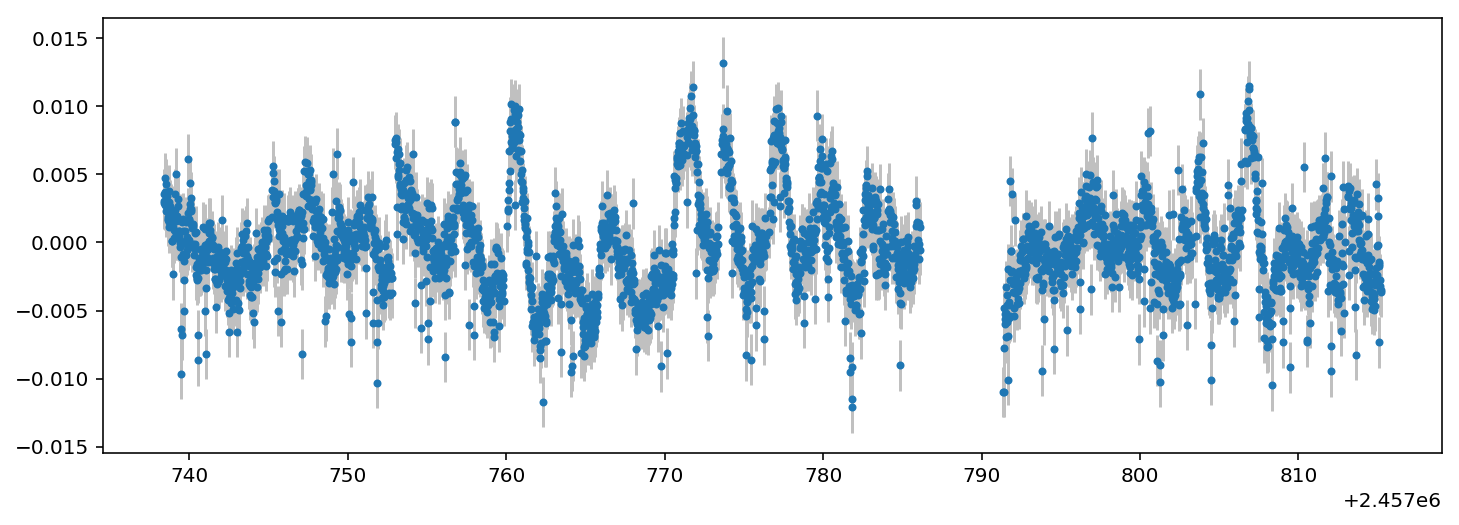

In [74]:
plt.figure(figsize=(12, 4))
plt.errorbar(k2_time, k2_flux, k2_err, fmt='.', ecolor='silver')

In [114]:
terms.Matern32Term

In [127]:
import celerite
from celerite import terms

# Use the results from a prior optimization:
kernel = (terms.SHOTerm(-11.60656534,  -2.43609442,   np.log(3.3)) + 
          terms.SHOTerm(-8.60656534,  -2.43609442,   np.log(20)) + 
          terms.Matern32Term())

gp = celerite.GP(kernel, mean=np.mean(k2_flux))
gp.compute(k2_time, k2_err)  # You always need to call compute once.

In [128]:
from scipy.optimize import minimize

def neg_log_like(params, y, gp):
    gp.set_parameter_vector(params)
    return -gp.log_likelihood(y)

initial_params = gp.get_parameter_vector()
bounds = gp.get_parameter_bounds()

r = minimize(neg_log_like, initial_params, method="L-BFGS-B", bounds=bounds, args=(k2_flux, gp))
gp.set_parameter_vector(r.x)

In [129]:
gp.get_parameter_vector()

array([-12.99867927,  -1.45595232,   2.04438716, -13.88582044,
         1.00157555,   0.70774667])

In [130]:
x = np.arange(k2_time.min(), k2_time.max(), 1/24)
pred_mean, pred_var = gp.predict(k2_flux, x, return_var=True)
pred_std = np.sqrt(pred_var)

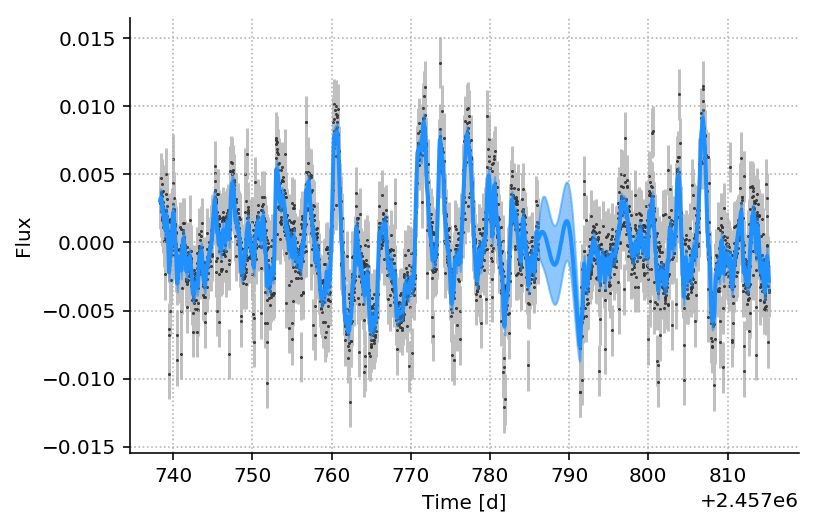

In [131]:
color = "DodgerBlue"
fig, ax = plt.subplots()
ax.errorbar(k2_time, k2_flux, k2_err, fmt=".", ecolor='silver', 
             capsize=0, color='#333333', zorder=-100, ms=1)
ax.plot(x, pred_mean, color=color, lw=2)
ax.fill_between(x, pred_mean + pred_std, pred_mean - pred_std, color=color, alpha=0.5,
                 edgecolor="none")
ax.set_xlabel("Time [d]")
ax.set_ylabel("Flux")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.legend()
ax.grid(ls=':')

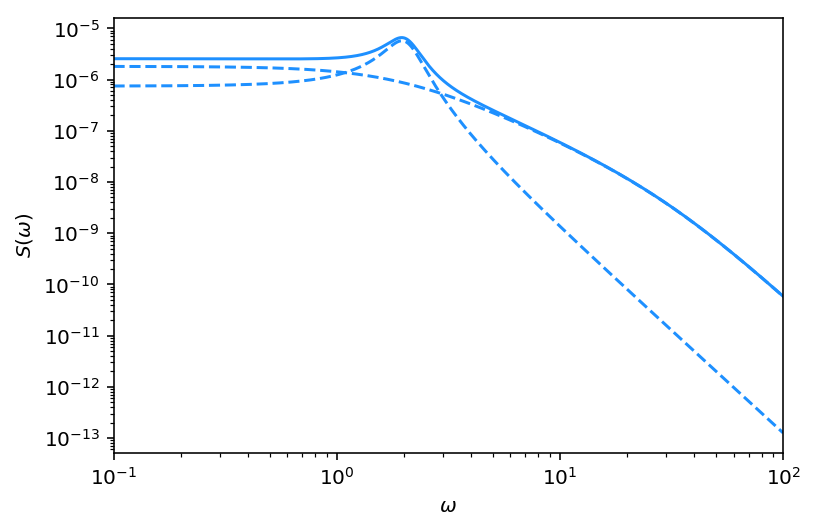

In [132]:
omega = np.exp(np.linspace(np.log(0.1), np.log(100), 5000))
psd = gp.kernel.get_psd(omega)

plt.plot(omega, psd, color=color)
for k in gp.kernel.terms:
    plt.plot(omega, k.get_psd(omega), "--", color=color)

plt.yscale("log")
plt.xscale("log")
plt.xlim(omega[0], omega[-1])
plt.xlabel("$\omega$")
plt.ylabel("$S(\omega)$");

In [134]:
from interpacf import interpolated_acf, dominant_period

lag, acf = interpolated_acf(k2_time, k2_flux)

In [143]:
from gatspy import periodic

model = periodic.LombScargleFast(fit_period=True)
model.optimizer.period_range = (1, 40)
model.fit(k2_time, k2_flux, k2_err);
model.best_period

Finding optimal frequency:
 - Estimated peak width = 0.0818
 - Using 5 steps per peak; omega_step = 0.0164
 - User-specified period range:  1 to 40
 - Computing periods at 376 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps


3.2970160009825036

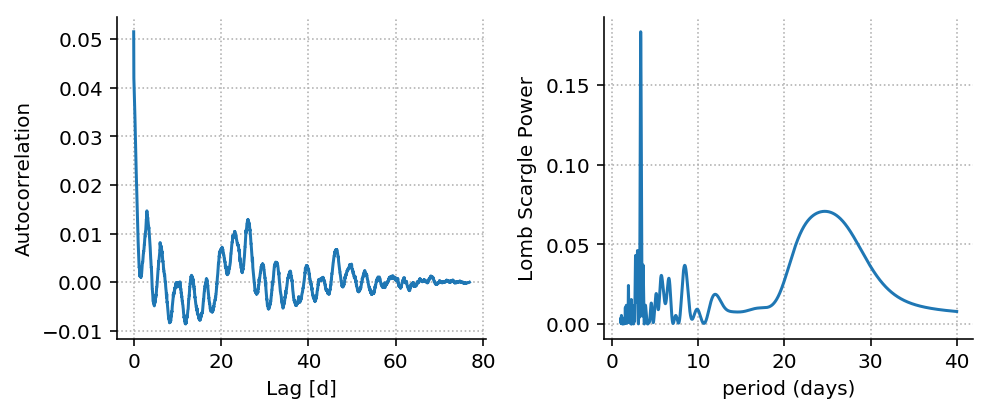

In [146]:
fig, ax = plt.subplots(1, 2, figsize=(7, 3))
#ax[0].semilogy(lag, acf)
ax[0].plot(lag, acf)
#ax[0].set_xlim([0, 2])
#ax[0].set_ylim([1e-5, 1e-2])
ax[0].set_xlabel('Lag [d]')
ax[0].set_ylabel('Autocorrelation')

# lagrange = ((lag > 0.4) & (lag < 0.6))
# peak_acf = lag[lagrange][np.argmax(acf[lagrange])]
# ax[0].set_title("P = {0:.5f} d".format(peak_acf))

# Compute the scores on a grid of periods
periods = np.linspace(model.optimizer.period_range[0], model.optimizer.period_range[1], 10000)

import warnings
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    scores = model.score(periods)
# ax[1].set_title("P = {0:.5f} d".format(model.best_period))
ax[1].plot(periods, scores)
ax[1].set(xlabel='period (days)', ylabel='Lomb Scargle Power',
          )

for axis in ax: 
    axis.spines['right'].set_visible(False)
    axis.spines['top'].set_visible(False)
    axis.grid(ls=':')
    
fig.tight_layout()
fig.savefig('k2_quasiperiodic.pdf')

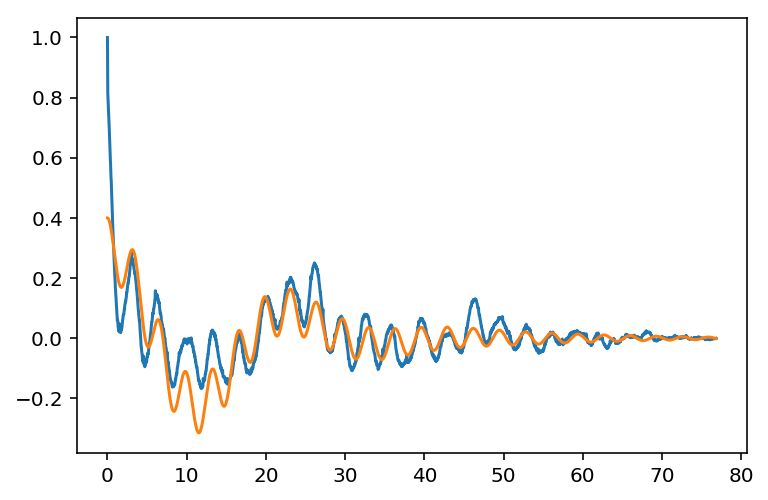

In [224]:
plt.plot(lag, acf/acf.max())

#k(xi,xj)=exp(−Γsin2[πP∣∣xi−xj∣∣])
#model = np.exp( - 10 * np.sin( np.pi * lag / 20)**2)

model = (0.3 * np.cos(2 * np.pi * lag / 24) * np.exp(-0.5 * (lag)**2 / 15**2) + 
         0.1 * np.cos(2 * np.pi * lag / 3.3) * np.exp(-0.5 * (lag)**2 / 30**2) )

plt.plot(lag, model)

In [227]:
import george
from george import kernels

kernel = (0.3 * kernels.ExpSquaredKernel(np.log(15)) * kernels.CosineKernel(np.log(24)) + 
          0.1 * kernels.ExpSquaredKernel(np.log(30)) * kernels.CosineKernel(np.log(3.3)))

gp = george.GP(kernel)
gp.compute(k2_time, k2_err)

In [228]:
from scipy.optimize import minimize

def neg_ln_like(p):
    gp.set_parameter_vector(p)
    return -gp.log_likelihood(k2_flux)

def grad_neg_ln_like(p):
    gp.set_parameter_vector(p)
    return -gp.grad_log_likelihood(k2_flux)

result = minimize(neg_ln_like, gp.get_parameter_vector(), jac=grad_neg_ln_like)
print(result)

gp.set_parameter_vector(result.x)
print("\nFinal ln-likelihood: {0:.2f}".format(gp.log_likelihood(k2_flux)))

      fun: -16201.941162471589
 hess_inv: array([[  6.80301229e-02,   1.14278905e-01,   8.61459811e+00,
          7.89218249e-03,   5.61960208e-02,  -3.33903629e-01],
       [  1.14278905e-01,   3.60783077e-01,  -1.31720362e+02,
          1.54676865e-02,   9.54778122e-02,   3.63810744e+00],
       [  8.61459811e+00,  -1.31720362e+02,   4.33389418e+05,
         -8.64850988e-01,   4.73461429e+01,  -1.27046979e+04],
       [  7.89218249e-03,   1.54676865e-02,  -8.64850988e-01,
          3.03025126e-02,   2.20297002e-02,   2.00845957e-02],
       [  5.61960208e-02,   9.54778122e-02,   4.73461429e+01,
          2.20297002e-02,   8.68012817e-02,  -1.45377973e+00],
       [ -3.33903629e-01,   3.63810744e+00,  -1.27046979e+04,
          2.00845957e-02,  -1.45377973e+00,   3.72605921e+02]])
      jac: array([ -1.07851865e-06,  -1.26855737e-05,  -5.60326426e-07,
         6.02526788e-07,   2.97512929e-06,  -1.90493536e-05])
  message: 'Desired error not necessarily achieved due to precision loss.

In [229]:
x = np.arange(k2_time.min(), k2_time.max(), 1/24)
pred_mean, pred_var = gp.predict(k2_flux, x, return_var=True)
pred_std = np.sqrt(pred_var)

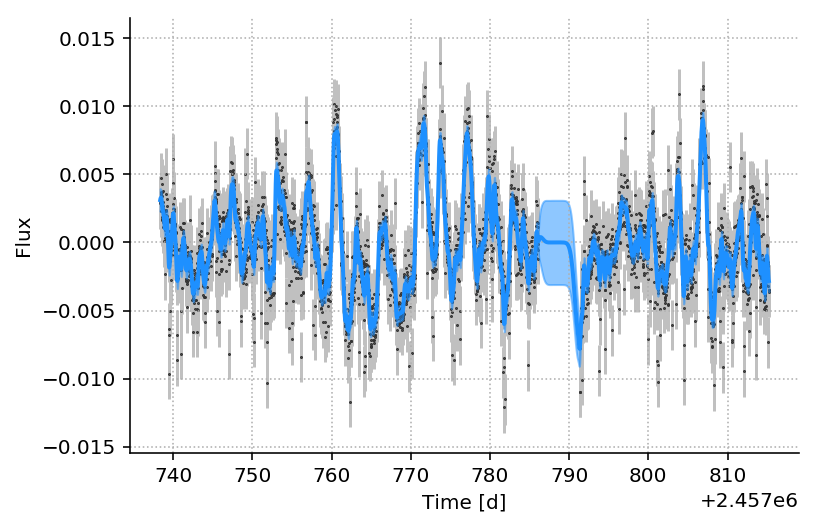

In [230]:
color = "DodgerBlue"
fig, ax = plt.subplots()
ax.errorbar(k2_time, k2_flux, k2_err, fmt=".", ecolor='silver', 
            capsize=0, color='#333333', zorder=-100, ms=1)
ax.plot(x, pred_mean, color=color, lw=2)
ax.fill_between(x, pred_mean + pred_std, pred_mean - pred_std, color=color, alpha=0.5,
                edgecolor="none")
ax.set_xlabel("Time [d]")
ax.set_ylabel("Flux")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.legend()
ax.grid(ls=':')